In [58]:
import numpy as np
import pandas as pd
import random
import os

from pyprojroot import here
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer


from sklearn.metrics import roc_curve, auc as sk_auc
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbModelCheckpoint


random.seed(7)

In [59]:
raw_data = pd.read_csv(here('data/raw/ai4i2020.csv'))


In [60]:
raw_data_copy = raw_data.copy()
raw_data_copy = raw_data_copy.drop(columns=['UDI','Product ID'])
raw_data_copy.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [61]:
#Grabbing my joint distributions
#These were imported from my class Imbalance exploration notebook. These are grounded truth
joint_events = {'event2':('PWF','OSF'),'event7':('TWF','RNF'),'event8':('HDF','PWF'),
                'event9':('HDF','OSF'),'event10':('TWF','OSF'),
                'event11':('TWF','PWF','OSF')}

BASE = ['TWF','HDF','PWF','OSF','RNF']

# Lets define a function that will select rows based on the condition that they have joint failure modes enabled

def joint_failure_events(events:dict, dataFrame):
    series_of_joint_failures = {}
    for k, v in events.items():
        if k == 'event11':  # triple
            name = 'joint_' + '_'.join(joint_events['event11'])
            others = [c for c in BASE if c not in ('TWF','PWF','OSF')]
            mask = ((dataFrame[v[0]] == 1) & (dataFrame[v[1]] == 1) & (dataFrame[v[2]] == 1) &
                    dataFrame[others].eq(0).all(axis=1))
            series_of_joint_failures[name] = dataFrame.loc[mask].copy()
        else:               # pairwise
            name = 'joint_' + '_'.join(joint_events[k])
            others = [c for c in BASE if c not in v]
            mask = ((dataFrame[v[0]] == 1) & (dataFrame[v[1]] == 1) &
                    dataFrame[others].eq(0).all(axis=1))
            series_of_joint_failures[name] = dataFrame.loc[mask].copy()
    return series_of_joint_failures


#Now create new targets of joint failures. These will be toggled on where there is a recorded joint failure
#Toggled off where there is none and in the corresponding joint failure mode the joint observation will be turned off
def apply_joint_vectors_from_lookup(dataFrame, joints_dict):
    df = dataFrame.copy()
    for joint_name, subdf in joints_dict.items():
        if joint_name not in df.columns:
            df[joint_name] = 0
        idx = subdf.index
        df.loc[idx, joint_name] = 1
        labels = joint_name.split('joint_')[1].split('_')  # e.g. ['TWF','PWF','OSF']
        df.loc[idx, labels] = 0
    return df


look_see = joint_failure_events(joint_events,raw_data_copy)
#print(look_see)
raw_datawithjoints = apply_joint_vectors_from_lookup(raw_data_copy,look_see)
print(raw_datawithjoints.head())

  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0         42.8                0                0    0    0    0    0    0   
1         46.3                3                0    0    0    0    0    0   
2         49.4                5                0    0    0    0    0    0   
3         39.5                7                0    0    0    0    0    0   
4         40.0                9                0    0    0    0    0    0   

   joint_PWF_OSF  joint_TWF_RNF  joint_HDF_PWF  joint_HD

In [62]:
#Sanity checking that the events in my sample space add up and still hold true to the Axioms of probability
base_labels  = ['TWF','HDF','PWF','OSF','RNF']
joint_labels = ['joint_PWF_OSF','joint_TWF_RNF','joint_HDF_PWF',
                'joint_HDF_OSF','joint_TWF_OSF','joint_TWF_PWF_OSF']
class_labels = base_labels + joint_labels

# 2) Build the sample-space table by MERGING on keys (not by positional values)
sample_space_df = raw_datawithjoints[class_labels].drop_duplicates()

counts = (raw_datawithjoints
          .groupby(class_labels, sort=False)
          .size()
          .reset_index(name='count'))

sample_space_df = sample_space_df.merge(counts, on=class_labels, how='left')
sample_space_df['P(outcome)'] = sample_space_df['count'] / len(raw_datawithjoints)

print(sample_space_df)
print(f"Sample Space is {sample_space_df['P(outcome)'].sum():.1f}, "
      f"size of sample space is {2**len(class_labels)}")


    TWF  HDF  PWF  OSF  RNF  joint_PWF_OSF  joint_TWF_RNF  joint_HDF_PWF  \
0     0    0    0    0    0              0              0              0   
1     0    0    1    0    0              0              0              0   
2     0    0    0    0    0              1              0              0   
3     1    0    0    0    0              0              0              0   
4     0    0    0    1    0              0              0              0   
5     0    0    0    0    1              0              0              0   
6     0    1    0    0    0              0              0              0   
7     0    0    0    0    0              0              1              0   
8     0    0    0    0    0              0              0              1   
9     0    0    0    0    0              0              0              0   
10    0    0    0    0    0              0              0              0   
11    0    0    0    0    0              0              0              0   

    joint_H

# The sample space and the sample space size are exactly equal and there are no events missing for from the original event space and no new events observed. From here I will assume according to EDA, the axioms of probability and the mass of the new events that the data is correct.

In [63]:
raw_datawithjoints.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,joint_PWF_OSF,joint_TWF_RNF,joint_HDF_PWF,joint_HDF_OSF,joint_TWF_OSF,joint_TWF_PWF_OSF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
#Scale/encode and send to wandb

class_labels = list(raw_datawithjoints.columns[7:])
targets = class_labels

# only the continuous feature columns to scale (do NOT include targets here)
num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
]

# encode+scale FEATURES ONLY
preproc = ColumnTransformer(
    transformers=[
        ('type_enc', OrdinalEncoder(categories=[['L','M','H']], dtype=int), ['Type']),
        ('num_scale', StandardScaler(), num_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# fit/transform on the feature subset (Type + numeric features)
X_feat = raw_datawithjoints[['Type'] + num_cols]
X_proc = preproc.fit_transform(X_feat)

# put back clean columns
proc_cols = ['quality_variation'] + num_cols
X_proc_df = pd.DataFrame(X_proc, columns=proc_cols, index=raw_datawithjoints.index)
X_proc_df['quality_variation'] = X_proc_df['quality_variation'].astype(int)

# build complete dataframe with encoding, scaling and new targets
Y_df = raw_datawithjoints.loc[:, targets].copy()
df_out = X_proc_df.join(Y_df)

print(df_out.head())

# Save locally
df_out.to_csv(here('data/processed/joint_target_vectors_df.csv'), index=False)

# upload to wandb
wandb.login()
run = wandb.init(project='predictive-maintenance',
                 entity='w207-predictive-maintenance',
                 job_type="dataset-upload")

artifact = wandb.Artifact(
    name='joint_target_vectors_df',
    type='dataset',
    description="Juba's vectorized joint failures encoded and scaled"
)
artifact.metadata['info'] = 'Scaled | Encoded | feature engineering on targets'
artifact.add_file(here('data/processed/joint_target_vectors_df.csv'))
run.log_artifact(artifact)
run.finish()


   quality_variation  Air temperature [K]  Process temperature [K]  \
0                  1            -0.952389                -0.947360   
1                  0            -0.902393                -0.879959   
2                  0            -0.952389                -1.014761   
3                  0            -0.902393                -0.947360   
4                  0            -0.902393                -0.879959   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                0.068185     0.282200        -1.695984    0    0    0    0   
1               -0.729472     0.633308        -1.648852    0    0    0    0   
2               -0.227450     0.944290        -1.617430    0    0    0    0   
3               -0.590021    -0.048845        -1.586009    0    0    0    0   
4               -0.729472     0.001313        -1.554588    0    0    0    0   

   RNF  joint_PWF_OSF  joint_TWF_RNF  joint_HDF_PWF  joint_HDF_OSF  \
0    0              0             

In [65]:
df_out

,quality_variation,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,joint_PWF_OSF,joint_TWF_RNF,joint_HDF_PWF,joint_HDF_OSF,joint_TWF_OSF,joint_TWF_PWF_OSF
0,1,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0,0,0,0,0,0,0,0,0,0,0
1,0,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0,0,0,0,0,0,0,0,0,0,0
2,0,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0,0,0,0,0,0,0,0,0,0,0
3,0,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0,0,0,0,0,0,0,0,0,0,0
4,0,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0,0,0,0,0,0,0,0,0,0,0
9996,2,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,0,0,0,0,0,0,0,0,0,0,0
9997,1,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0,0,0,0,0,0,0,0,0,0,0
9998,2,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,0,0,0,0,0,0,0,0,0,0,0


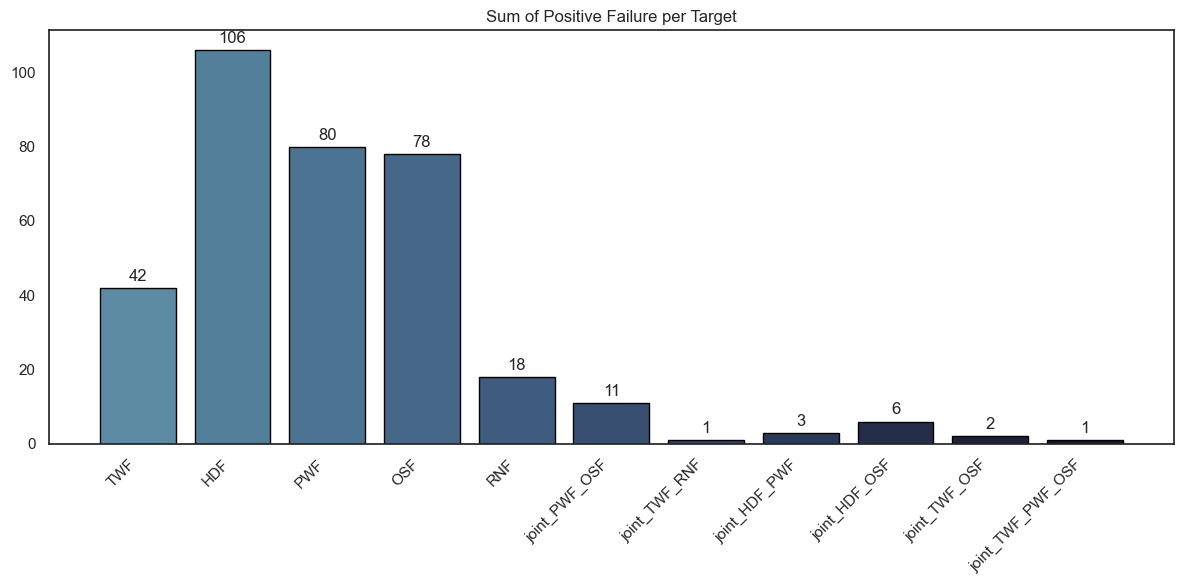

In [66]:
# a quick look at the true  failure modes
height = [int(df_out[p].sum()) for p in targets]
pal    = sns.cubehelix_palette(len(targets), rot=-.25, light=.5, dark=.1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('none'); fig.patch.set_alpha(0)

#theme
bars = ax.bar(range(len(targets)), height, edgecolor='black', color=pal)
ax.bar_label(bars, labels=[str(h) for h in height], padding=3)
ax.set_xticks(range(len(targets)))
ax.set_xticklabels(targets, rotation=45, ha='right')

ax.set_title('Sum of Positive Failure per Target')
fig.tight_layout()
